# 0. Eigenvalues, graphs, and optimization

**Example discrete optimization problem: given a weighted graph, cluster it in the best way into disconnected partitions, assuming that cutting expensive edges is bad.** Also know as MinCut problem.

The journey starts from [spectral graph theory](https://en.wikipedia.org/wiki/Spectral_graph_theory). The task of this block is to show, that there is a connection between combinatorial problems and finding eigenvalues.

What does `0.0` eignvalue of a [Laplacian matrix](https://en.wikipedia.org/wiki/Laplacian_matrix) mean? Linear dependencies. One of their realizations - connected components (the other is cycle). What will we observe if we bild a "weak" egde (bridge) between 2 connected components?

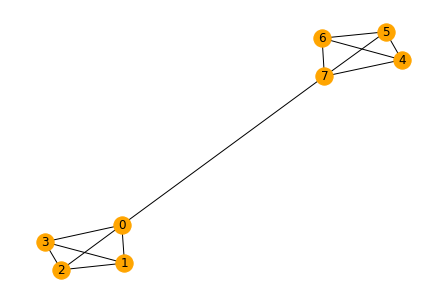

In [1]:
import numpy as np
import networkx as nx

num_nodes = 8

# bridged graph:
w = np.zeros((num_nodes, num_nodes))
w[:4, :4] = 1 - np.eye(4)
w[4:, 4:] = 1 - np.eye(4)
w[0, 7] = 0.1
w[7, 0] = 0.1

G = nx.from_numpy_matrix(w)
nx.draw(G, with_labels=True, node_color=['orange'])

This is a Laplacian matrix:

In [2]:
D = np.diag(w.sum(axis=1))
L = D - w

In [3]:
evals, evecs = np.linalg.eig(L)
print("Eigenvalues:")
print(np.round_(evals, 2))

Eigenvalues:
[-0.    0.05  4.15  4.    4.    4.    4.    4.  ]


The **smallest non-zero eigenvalue** here is exactly the one which correspord to *"weak dependency"*.

How does this "correspond" work? Eigenvalue has a corresponding eigenvector. In a node's eigendecomposition, multiplier in front of this vector is similar for the "close" nodes, and different for distant.

Thus they can work as features for clustering. This is a basis of [Shi-Malik spectral clustering](https://stats.stackexchange.com/questions/96539/motivations-for-shi-malik-algorithm).

Or even simpler, eigenvector act as normal vectors to separating hyperplane (as in logistic regression):

In [4]:
# eigenvector for smallest eigenvalue
# Is it "to the left" or "to the right"?
L @ evecs[:, 1] > 0

array([ True,  True,  True,  True, False, False, False, False])

See also [this](https://web.cs.elte.hu/~lovasz/eigenvals-x.pdf) explainer by Abel Prize winner :).

# 1. Ising Model

[Ising Model](https://en.wikipedia.org/wiki/Ising_model) is the model of energy for a magnetic material organized in a (crystal) grid. Neighbour "spins" ($S=\pm1$) of atoms in the grid should be the same ($S_iS_j=1$) to minimize total energy. Energy operator - Hamiltonian, $\mathcal{H} = -J\sum_{L_1(i, j)=1}S_iS_j$. As in minimal energy case all spins look in the same direction, we have a magnet! (*comment* - if $J<0$ this is called antiferromagnetism, spins tend to alternate, and in total material remains magnetically neutral).

![](https://lh3.googleusercontent.com/proxy/5hqUDfHS9BVL_j047t2xwnPgxxYbu6dsP3KPoW7c37SvBAL63oq79cmkDQPV02TFRVIfi5K2YxmmMUlg4B0PLY1qceccyY7WO_Cxl_3LzqVo)

Temperature increases the probabily of high-engery states $\propto e^{-\frac{\mathcal{H}}{T}}$.
A lot of optimization problems can be turned into Ising formulation. [This paper covers the methods of conversion](https://arxiv.org/abs/1302.5843). Ising model lays in the basis of [quantum annealing](https://en.wikipedia.org/wiki/Quantum_annealing) method, and D-Wave implementation of adiabatic non-universal quantum computer.

# 2. VQE

[Variational Quantum Eigensolver](https://towardsdatascience.com/the-variational-quantum-eigensolver-explained-adcbc9659c3a) -- is a hydrid quantum-classical method to find the **lowest eigenvalue of a given Hamiltonian**. Idealogically it repeats quantum annealing (which can be encoded on non-universal QPU) on universal QPU.

It can be imagined as a gradient descent on a smooth function (of energy) $\mathcal{H}(\theta)$, where $|\psi(\theta)\rangle$ is tuned to minimize $\langle\psi_\theta|\mathcal{H}|\psi_\theta\rangle$. So, optimization step for $\theta$ is done on a classical machine, while energy estimation runs on a QPU.

<img src="https://miro.medium.com/max/700/1*TvB2W5sqAJ4HXvIPHBKgqQ.png" width="400"/>

Convertation from $\theta$ to $|\psi(\theta)\rangle$ is done by [ansatz](https://en.wikipedia.org/wiki/Ansatz) - an educated guess about representation of parameters in a form of a vector, namely, set of quantum gates $|\psi\rangle=Ansatz_\theta|0\rangle$.

# 4. QAOA

Based on [Pennylane QAOA tutorial](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html) and [QAOA for MaxCut](https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html).

[Quantum Approximate Optimization Algorithm (QAOA)](https://qiskit.org/textbook/ch-applications/qaoa.html) (also [pennylane docs](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html)) is an advance of VQE, which is optimized to have only 2 parameters $\beta, \gamma$. Typical illustration for it is a [Max-Cut problem](https://en.wikipedia.org/wiki/Maximum_cut) -- maximum cut (set of edges, removing which you disjoin the graph) is a cut whose size is at least the size of any other cut.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/Max-cut.svg/220px-Max-cut.svg.png).

If we encode node assigments to partitions as $0, 1$, then we can use a quantum state, e.g. $|\psi\rangle=|0110\rangle$, to represent the "best" assignment (means -- cutting a lot of heavy edges).

The algorithm starts from some (usually equally superposed state) and iterates through
$\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})                             \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p \; \text{times}} \lvert \psi_0 \rangle$, where
- $U(\boldsymbol{\beta})=e^{-i\beta H_B}$ -- unitary for a "mixing" Hamiltonian $H_B$, adjusted by $\beta$.
  - The role of a mixer: ["The purpose of the mixer term is to make sure that if somehow your trial state is an eigenstate of the cost Hamiltonian HC, that is HC|ψ(θ)⟩=E|ψ(θ)⟩, then you can get out of this state" and "You can't go down in energy (that is, in "cost") by choosing different values of γ."](https://quantumcomputing.stackexchange.com/questions/17555/whats-the-role-of-mixer-in-qaoa)
- $U(\boldsymbol{\gamma})=e^{-i\gamma H_P}$ -- unitary for a problem (cost)Hamiltonian $H_P$, adjusted by $\gamma$.

Mixer Hamiltonian $H_B$ is usually in the form of:

$H_B = \big(X_0 \otimes I_1 \otimes I_2 \otimes I_3 \big) +      \big(I_0 \otimes X_1 \otimes I_2 \otimes I_3 \big) +\big(I_0 \otimes I_1 \otimes X_2 \otimes I_3 \big) +\big(I_0 \otimes I_1 \otimes I_2 \otimes X_3 \big)$

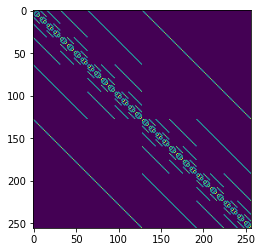

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def Tx(*args):
    r = args[0]
    for m in args[1:]:
        r = np.kron(r, m)
    return r

I = np.eye(2)
X = 1 - I
H_B = Tx(X, I, I, I) + Tx(I, X, I, I) + Tx(I, I, X, I) + Tx(I, I, I, X)
H_B = Tx(H_B, Tx(I, I, I, I)) + Tx(Tx(I, I, I, I), H_B)
plt.imshow(H_B)

**Combinatorial problem as minimization problem**.

In binary combinatorial optimization problems, the cost function $C(x)$  can typically be expressed as a sum of terms that only involve a subset $Q\subset[n]$  of the  $n$
bits in the string  $x\in\{0,1\}^n$   and is written in the canonical form.


$C(x) = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} \; \prod_{i\in Q} x_i \; \prod_{j\in \overline{Q}} (1- x_j),$ 

where $x_j\in\{0, 1\}$, and $w\in\mathbb{R}$. For our maxcut problem $w$ is an edge weight between clusters $Q$ and $\overline{Q}$!

This cost function can be mapped to a Hamiltonian that is diagonal in the computational basis. Given the cost-function  $C$ this Hamiltonian is then written as:


$H = \sum_{x \in \{0,1\}^n} C(x) |x \rangle\langle x|$.

The expansion of $H$  in to Pauli  $Z$  operators can be obtained from the canonical expansion of the cost-function  $C$  by substituting for every binary variable  
$x_i\in\{0,1\}$ the matrix $x_i=\frac{1}{2}(1-Z_i)$, where $Z_i$ acts on a single qubit: $Z_i=I^{(0)}\otimes I^{(1)}\otimes...\otimes Z^{(i)}\otimes...\otimes I^{(n-1)}$

$H = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} \; \frac{1}{2^{|Q| + |\overline{Q}|}}\prod_{i\in Q} \left(1 - Z_i\right) \; \prod_{j\in \overline{Q}} \left(1 + Z_j\right).$

In [ ]:
!pip install pennylane tqdm

[The weighted min-cut problem allowing both positive and negative weights can be trivially transformed into a weighted maximum cut problem by flipping the sign in all weights.](https://en.wikipedia.org/wiki/Minimum_cut)

[[0.  0.  0.  0.  1.  1.  1.  0.9]
 [0.  0.  0.  0.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  1.  1.  1.  1. ]
 [1.  1.  1.  1.  0.  0.  0.  0. ]
 [1.  1.  1.  1.  0.  0.  0.  0. ]
 [1.  1.  1.  1.  0.  0.  0.  0. ]
 [0.9 1.  1.  1.  0.  0.  0.  0. ]]
problem Hamiltonian:
   (-16.0) [I0]
+ (1.0) [Z0 Z4]
+ (1.0) [Z0 Z5]
+ (1.0) [Z0 Z6]
+ (1.0) [Z0 Z7]
+ (1.0) [Z1 Z4]
+ (1.0) [Z1 Z5]
+ (1.0) [Z1 Z6]
+ (1.0) [Z1 Z7]
+ (1.0) [Z2 Z4]
+ (1.0) [Z2 Z5]
+ (1.0) [Z2 Z6]
+ (1.0) [Z2 Z7]
+ (1.0) [Z3 Z4]
+ (1.0) [Z3 Z5]
+ (1.0) [Z3 Z6]
+ (1.0) [Z3 Z7]
Mixer:
   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1) [X5]
+ (1) [X6]
+ (1) [X7]


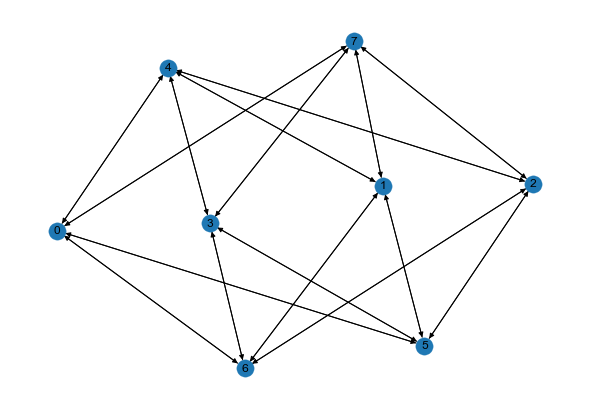

In [12]:
from pennylane import qaoa
import pennylane as qml

# just a hack to remove loops
w_i = 1 - w - np.eye(8)

print(w_i)
G_i = nx.DiGraph(w_i)
nx.draw(G_i, with_labels=True)
cost_h, mixer_h = qaoa.maxcut(G_i)

print("problem Hamiltonian:\n", cost_h)
print("Mixer:\n", mixer_h)

So far we have seen that the preparation of a quantum state during QAOA is composed of three elements

Preparing an initial state:
- Applying the unitary $U(H_P)$ depending on $\gamma$,
- Then, applying the mixing unitary $U(H_B)$ depending on $\beta$.

The next step is to find the optimal parameters $(\beta_{opt}, \gamma_{opt})$, such that the expectation value $\langle \psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rvert H_P \lvert \psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rangle$ (i.e. measurement in the Z-basis) is minimized.

<img src="https://qiskit.org/textbook/ch-applications/images/QAOA_schematic.png" width="300">

In [8]:
# wires are qubits
wires = range(8)

# ~backend
dev = qml.device("default.qubit", wires=wires)

# create layers (in terms of ML, or gates in terms of QPU)
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(beta, mixer_h)
       
# initialization parameters, gamma, beta
gamma_beta = qml.numpy.array([[0.0, 0.4], [0.2, 0.0]], requires_grad=True)

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    # depth (number of repetitions) is 2. We have 2 gammas and 2 betas
    qml.layer(qaoa_layer, 2, params[0], params[1])


@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

drawer = qml.draw(cost_function)
print(drawer(params=gamma_beta))


from tqdm.notebook import tqdm

optimizer = qml.GradientDescentOptimizer()
steps = 700
for i in tqdm(range(steps)):
    gamma_beta = optimizer.step(cost_function, gamma_beta)

print("Optimal Parameters")
print(gamma_beta)

 0: ──H──╭RZ(0)──────────╭RZ(0)──────────────────╭RZ(0)──────────────────────────╭RZ(0)──H──────────────────────────RZ(0.4)──────────────────H─────────────────────────╭RZ(0.8)─────────────────────╭RZ(0.8)─────────────────────────╭RZ(0.8)────────────────────────────────╭RZ(0.8)──H────────────────────────────────RZ(0)──────────────────────H─────────────────────────────────╭┤ ⟨Hamiltonian(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -16)⟩ 
 1: ──H──│───────╭RZ(0)──│───────────────╭RZ(0)──│───────────────────────╭RZ(0)──│──────────────────────────╭RZ(0)──H────────────────────────RZ(0.4)──────────H────────│──────────────────╭RZ(0.8)──│──────────────────────╭RZ(0.8)──│─────────────────────────────╭RZ(0.8)──│────────────────────────────────╭RZ(0.8)──H──────────────────────────RZ(0)────────────H────────────────├┤ ⟨Hamiltonian(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -16)⟩ 
 2: ──H──│───────│───────│───────╭RZ(0)──│───────│───────────────╭RZ(0)──│───────│──────────────────╭RZ(0)──│───

  0%|          | 0/700 [00:00<?, ?it/s]

Optimal Parameters
[[-1.31543701  0.40846651]
 [ 1.46325082 -0.54950906]]


With the optimal parameters, we can now reconstruct the probability landscape. We redefine the full QAOA circuit with the optimal parameters, but this time we return the probabilities of measuring each bitstring:

In [9]:
@qml.qnode(dev)
def probability_circuit(gamma, beta):
    circuit([gamma, beta])
    return qml.probs(wires=wires)

probs = probability_circuit(gamma_beta[0], gamma_beta[1])

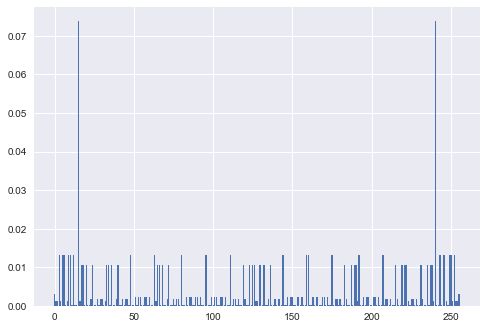

In [10]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

In [11]:
for idx in np.argsort(probs)[-4:]:
    bitstr = f"{idx:08b}"
    print(bitstr, ": prob", probs[idx])

10100000 : prob 0.013215001362476678
01011111 : prob 0.013215001362476678
00001111 : prob 0.0738559216163497
11110000 : prob 0.0738559216163497
